# Refine waterbodies <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[wofs_albers](https://explorer.sandbox.dea.ga.gov.au/wofs_albers),
[DEA Waterbodies](https://www.ga.gov.au/dea/products/dea-waterbodies)
* **Special requirements:** [Lake Tuggeranong 2015 bathymetry extent](https://data.gov.au/dataset/ds-actmapi-http%3A%2F%2Factmapi-actgov.opendata.arcgis.com%2Fdatasets%2Fa7450c9e3c964e80b0a9b5b0d5eda416_12/details?q=bathymetry%20lake%20tuggeranong) in shapefile format

## Description
DEA Waterbodies uses WOfS, a classification of Landsat pixels into wet and dry, to identify and track waterbodies throughout the Australian continent. One limitation is the size of the Landsat pixels, 25 m x 25 m, which can be quite large compared to the size of some waterbodies. Can we identify the maximum extent of a waterbody better than a whole pixel approach, as in e.g. Bishop-Taylor et al. (2019; https://doi.org/10.3390/rs11242984) or Sall et al. (2020; https://doi.org/10.1002/rse2.172)? How would this affect our time series?

To test subpixel extent on a best-case scenario, we will use a similar subpixel method to refine Lake Tuggeranong in DEA Waterbodies. The boundary can be extracted from the [Lake Tuggeranong point cloud](https://data.gov.au/dataset/ds-actmapi-http%3A%2F%2Factmapi-actgov.opendata.arcgis.com%2Fdatasets%2Fdd847818f069414d85ebf249f89ea04c_10) which I have already done in QGIS. The lake is wet in all Landsat observations and has a well-defined boundary. We will compare our method to this true extent.

Lake Tuggeranong's steep edges make WOfS summary statistics remarkably sharp on the edges, which we can use to make a really tight boundary. However, this means that any threshold between 0% and 100% will give a reasonable waterbody. I anticipate that the subpixel approach will perform best when it has a soft boundary, as the threshold essentially changes where the subpixel boundary is drawn. For a sharp divide like Lake Tuggeranong, the threshold controls how buffered the boundary is. For this reason we will also use a softer-edged waterbody as a test, and this will be Reedy Lake.


***

## Getting started

Run all cells in the notebook to run the analysis.

### Load packages

In [28]:
%matplotlib inline

import sys
import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import shapely
from tqdm.notebook import tqdm

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_spatialtools import xr_vectorize, subpixel_contours

### Load the Lake Tuggeranong extent data

Note that this is just the exterior polygon of the lake. It does not include the small islands in the northern part.

In [3]:
lte = gpd.read_file('lake_tuggeranong.geojson')

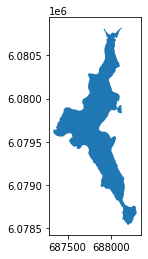

In [4]:
lte.plot()

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [5]:
dc = datacube.Datacube(app='RefineWaterbodies')

### Load the WOfS summary

The WOfS summary is used to define the waterbody maximum extent.

In [86]:
reedy_ylim = (-36.72976, -36.69260)
reedy_xlim = (145.07745, 145.14402)

In [87]:
wofs = {}
wofs['tuggeranong'] = dc.load('wofs_summary', geopolygon=datacube.utils.geometry.Geometry(lte.geometry[0].buffer(100), crs=lte.crs)).isel(time=0)
wofs['reedy'] = dc.load('wofs_summary', x=reedy_xlim, y=reedy_ylim).isel(time=0)

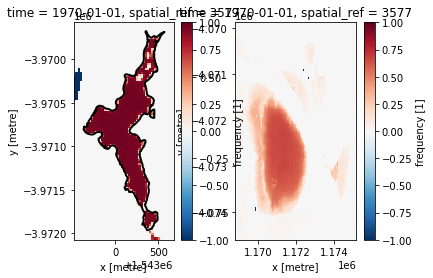

In [88]:
fig, axs = plt.subplots(1, 2)
wofs['tuggeranong'].frequency.plot(ax=axs[0])
lte.to_crs('EPSG:3577').plot(ax=axs[0], edgecolor='black', linewidth=2, facecolor='None')
wofs['reedy'].frequency.plot(ax=axs[1])

## Reproduce DEA Waterbodies

Find the 5% and 10% polygons, discard any under 5 px, and then do a spatial join.

In [89]:
wbs = {}

for wb, wof in wofs.items():
    pc_10 = xr_vectorize(wof.frequency >= 0.10, crs=wof.crs)
    pc_05 = xr_vectorize(wof.frequency >= 0.05, crs=wof.crs)

    pc_10 = pc_10[pc_10.attribute == 1]
    pc_05 = pc_05[pc_05.attribute == 1]
    
    # Discard polygons with under 5 px.
    pc_05 = pc_05[pc_05.area >= 25 ** 2]
    pc_10 = pc_10[pc_10.area >= 25 ** 2]
    
    # Then join.
    joined = gpd.sjoin(pc_05, pc_10, lsuffix='05', rsuffix='10', how='right')

    # Allow a 5% polygon as long as it intersects with a 10% polygon.
    ok_05 = set(joined.index_05)
    pc_05 = pc_05.loc[ok_05]
    
    wbs[wb] = pc_05.reset_index(drop=True)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


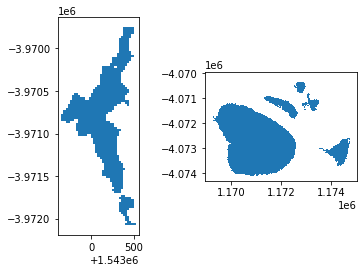

In [91]:
fig, axs = plt.subplots(1, 2)
wbs['tuggeranong'].plot(ax=axs[0])
wbs['reedy'].plot(ax=axs[1])

## Subpixel extent

Using `subpixel_contours`, find the subpixel extents of Lake Tuggeranong and Keepit Dam. We can set the contour levels to 5% and 10% as above, but we can also change them to other values. This modifies the eventual error in the boundary quite dramatically for Lake Tuggeranong, because Lake Tuggeranong has very steep edges, so there is a sharp jump.

In [92]:
wbs_subpixel = {}
for wb, wof in wofs.items():
    contours = subpixel_contours(wof.frequency, z_values=[0.05, 0.10]).set_index('z_value', drop=True)

    pc_05 = gpd.GeoDataFrame(geometry=[shapely.geometry.Polygon(ls) for ls in contours.iloc[0].geometry])
    pc_10 = gpd.GeoDataFrame(geometry=[shapely.geometry.Polygon(ls) for ls in contours.iloc[1].geometry])

    # Determine whether each polygon is an "inner" polygon or not.

    pc_10_agg = pc_10.geometry[0]
    for g in pc_10.geometry[1:]:
        pc_10_agg = pc_10_agg.symmetric_difference(g)

    pc_05_agg = pc_05.geometry[0]
    for g in pc_05.geometry[1:]:
        pc_05_agg = pc_05_agg.symmetric_difference(g)

    pc_05 = gpd.GeoDataFrame(geometry=list(pc_05_agg))
    pc_10 = gpd.GeoDataFrame(geometry=list(pc_10_agg))

    # Discard anything under 5 px.
    pc_05 = pc_05[pc_05.area >= 25 ** 2]
    pc_10 = pc_10[pc_10.area >= 25 ** 2]

    # Spatial join to find 5% extents for 10% polygons.
    joined = gpd.sjoin(pc_05, pc_10, lsuffix='05', rsuffix='10', how='right')
    pc_05 = pc_05.loc[joined.index_05]

    wbs_subpixel[wb] = pc_05.set_crs('EPSG:3577')

Operating in multiple z-value, single array mode
Operating in multiple z-value, single array mode


Combine both sets with a spatial join.

In [93]:
wbs_joined = {wb: gpd.sjoin(wbs[wb], wbs_subpixel[wb], how='left') for wb in wbs}

In [94]:
wbs_joined = {wb: wbs_joined[wb].join(wbs[wb], rsuffix='_wbs').join(wbs_subpixel[wb], on='index_right', rsuffix='_subpixel') for wb in wbs}

## Lake Tuggeranong comparison

Let's look at Lake Tuggeranong itself. It splits into three waterbodies thanks to bridges that cross it, but we can pull them out as the largest waterbodies.

In [95]:
lt_idxs = wbs_joined['tuggeranong'].area.argsort()[-3:]

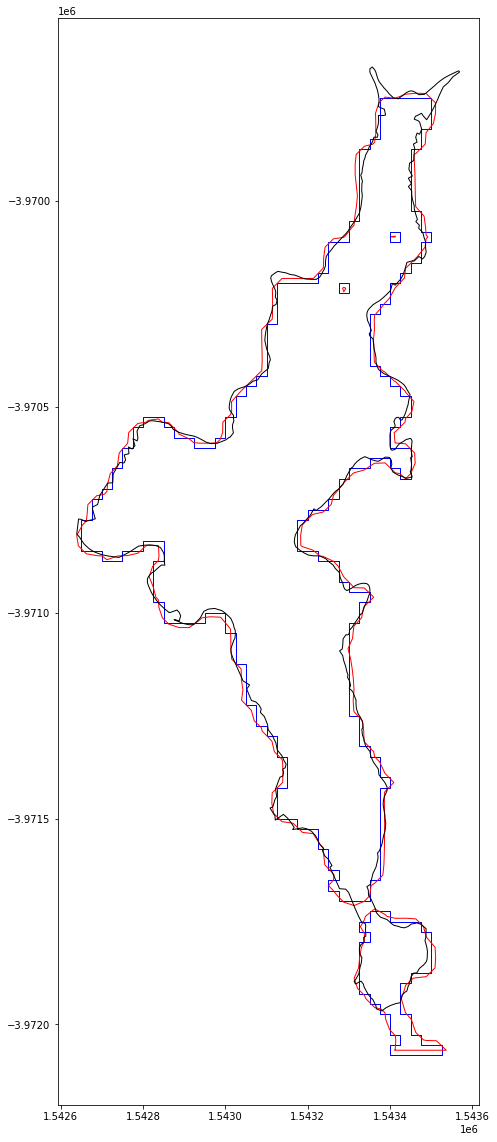

In [96]:
fig, ax = plt.subplots(figsize=(10, 20))
gpd.GeoDataFrame(geometry=wbs_joined['tuggeranong'].iloc[lt_idxs].geometry_wbs).plot(ax=ax, edgecolor='blue', facecolor='None')
gpd.GeoDataFrame(geometry=wbs_joined['tuggeranong'].iloc[lt_idxs].geometry_subpixel).plot(ax=ax, edgecolor='red', facecolor='None')
lte.to_crs('EPSG:3577').plot(ax=ax, edgecolor='k', facecolor='None')

We pick up the little islands using subpixel method, though admittedly with a large threshold.

Let's compare each linestring to the true extent by calculating the distance between each point and the extent.

In [97]:
comparison_geometry = lte.to_crs('EPSG:3577').iloc[0].geometry

buffer = 0

distances_wbs = []
for coord in tqdm(wbs_joined['tuggeranong'].iloc[0].geometry_wbs.buffer(buffer).exterior.coords):
    c = shapely.geometry.Point(coord)
    distances_wbs.append(c.distance(comparison_geometry))
    
distances_subpixel = []
for coord in tqdm(wbs_joined['tuggeranong'].iloc[0].geometry_subpixel.buffer(buffer).exterior.coords):
    c = shapely.geometry.Point(coord)
    distances_subpixel.append(c.distance(comparison_geometry))

In [98]:
mean_dist_wbs = np.mean(distances_wbs)
mean_dist_subpixel = np.mean(distances_subpixel)

In [99]:
mean_dist_wbs, mean_dist_subpixel

(5.830971083479178, 6.485127577731729)

## Reedy Lake comparison

We don't have a groundtruth for Reedy Lake, but we can compare it to DEA Waterbodies.

In [103]:
reedy_idxs = wbs_joined['reedy'].area.argsort()#.area.argsort()[-3:]

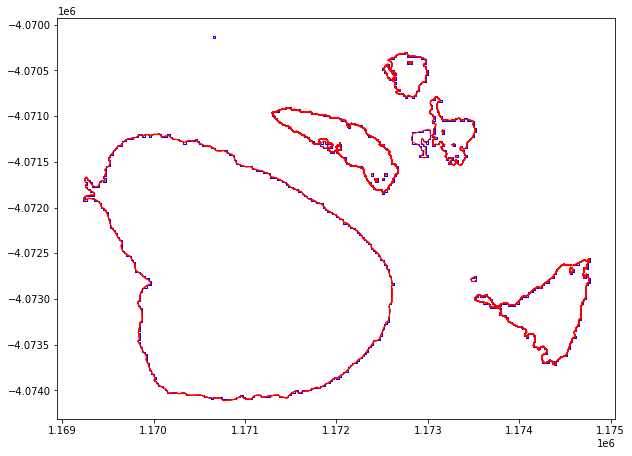

In [104]:
fig, ax = plt.subplots(figsize=(10, 20))
gpd.GeoDataFrame(geometry=wbs_joined['reedy'].iloc[reedy_idxs].geometry_wbs).plot(ax=ax, edgecolor='blue', facecolor='None')
gpd.GeoDataFrame(geometry=wbs_joined['reedy'].iloc[reedy_idxs].geometry_subpixel).plot(ax=ax, edgecolor='red', facecolor='None')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2020

**Compatible datacube version:** 

In [448]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)